In [74]:
from datasets import load_dataset
from PIL import ImageDraw
import matplotlib.pyplot as plt
import random
import numpy as np
import copy

# Load dataset funsd

In [31]:
dataset_funsd = load_dataset("nielsr/funsd-layoutlmv3")


nloading data:  69%|███████████████████████████████████████████████████████████████████████████████████▉                                     | 1.47G/2.13G [05:16<02:41, 4.04MB/s]

ading data:  53%|███████████████████████████████████████████████████████████████                                                         | 1.12G/2.13G [05:14<2:16:11, 123kB/s]

In [35]:
sample_index = 11

In [36]:
example = dataset_funsd['train'][sample_index]

# Extract the image (assumed to be a PIL image)
image = example['image']

# Get the image width and height
width, height = image.size
bboxes = example['bboxes']

print(width, height, "No value exceeds 1000" if any([x > 1000 for x in box] for box in bboxes) else "Has bbox value exceeds 1000") # Dataset is already normalized to scale 0-1000

762 1000 No value exceeds 1000


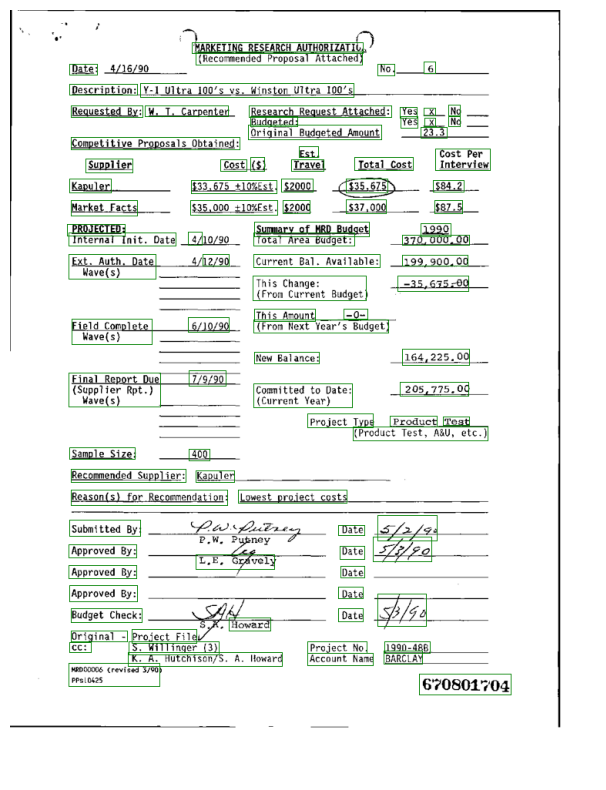

In [37]:
# Function to scale normalized bounding boxes to pixel coordinates
def scale_bbox(bbox, width, height):
    x0, y0, x1, y1 = bbox
    # print("before: ", x0, y0, x1, y1)
    x0 = int(x0 * width / 1000)
    y0 = int(y0 * height / 1000)
    x1 = int(x1 * width / 1000)
    y1 = int(y1 * height / 1000)
    # print("after: ", x0, y0, x1, y1)
    return [x0, y0, x1, y1]

# Draw the bounding boxes on the image
draw = ImageDraw.Draw(image)
for bbox in bboxes:
    scaled_bbox = scale_bbox(bbox, width, height)
    draw.rectangle(scaled_bbox, outline="green")

# Display the image with bounding boxes
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('off')
plt.show()

# Load dataset CORD

In [43]:
dataset_cord = load_dataset("nielsr/cord-layoutlmv3", trust_remote_code=True)
print(32423423)

32423423


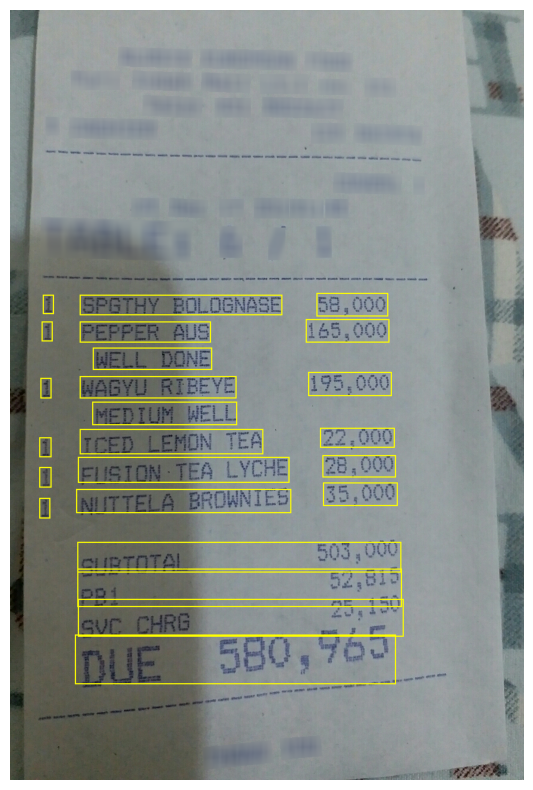

In [104]:
# Function to scale bounding boxes (if needed)
# CORD uses pixel coordinates directly, but we'll ensure they fit the image
def scale_bbox(bbox, width, height):
    x0, y0, x1, y1 = bbox
    # print("before: ", x0, y0, x1, y1)
    x0 = int(x0 * width / 1000)
    y0 = int(y0 * height / 1000)
    x1 = int(x1 * width / 1000)
    y1 = int(y1 * height / 1000)
    # print("after: ", x0, y0, x1, y1)
    return [x0, y0, x1, y1]
    
#Extract the image (assumed to be a PIL image)
example = dataset_cord["train"][1]
image = example['image']
image_red = image.copy()
image_green = image.copy()
    
# Get the image width and height
width, height = image.size

# print(image, width, height)
    
# Extract the bounding boxes (list of [x0, y0, x1, y1] for each box)
bboxes = example['bboxes']

# Draw the bounding boxes on the image
draw = ImageDraw.Draw(image)
for bbox in bboxes:
    scaled_bbox = scale_bbox(bbox, width, height)
    draw.rectangle(scaled_bbox, outline="yellow", width=2)
    
# Display the image with bounding boxes
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('off')
plt.show()

In [130]:
def compute_iou(box1, box2):
    x1, y1, x2, y2 = box1
    x1_p, y1_p, x2_p, y2_p = box2

    xi1 = max(x1, x1_p)
    yi1 = max(y1, y1_p)
    xi2 = min(x2, x2_p)
    yi2 = min(y2, y2_p)

    inter_width = max(0, xi2 - xi1)
    inter_height = max(0, yi2 - yi1)
    inter_area = inter_width * inter_height

    box1_area = (x2 - x1) * (y2 - y1)
    box2_area = (x2_p - x1_p) * (y2_p - y1_p)

    iou = inter_area / (box1_area + box2_area - inter_area)
    return iou
    
def perturb_bbox(bbox, offset=10, iou_threshold=0.57, img_size=(640, 480)):
    x1, y1, x2, y2 = bbox
    width, height = x2 - x1, y2 - y1

    img_w, img_h = img_size
    best_bbox = bbox
    for _ in range(10):
        dx, dy = 0, 0
        direction = random.choice(["left", "right", "up", "down"])
        direction = "left"

        if direction == "left":
            # dx = -random.randint(20, max_offset)
            dx = -offset
        elif direction == "right":
            dx = random.randint(20, max_offset)
        elif direction == "up":
            dy = -random.randint(20, max_offset)
        elif direction == "down":
            dy = random.randint(20, max_offset)

        new_x1 = np.clip(x1 + dx, 0, img_w - width)
        new_y1 = np.clip(y1 + dy, 0, img_h - height)
        new_x2 = new_x1 + width
        new_y2 = new_y1 + height

        new_bbox = [new_x1, new_y1, new_x2, new_y2]
        iou = compute_iou(bbox, new_bbox)

        best_bbox = new_bbox
        # if iou >= iou_threshold:
        #     best_bbox = new_bbox
        #     break
    # print(bbox, best)
    return best_bbox

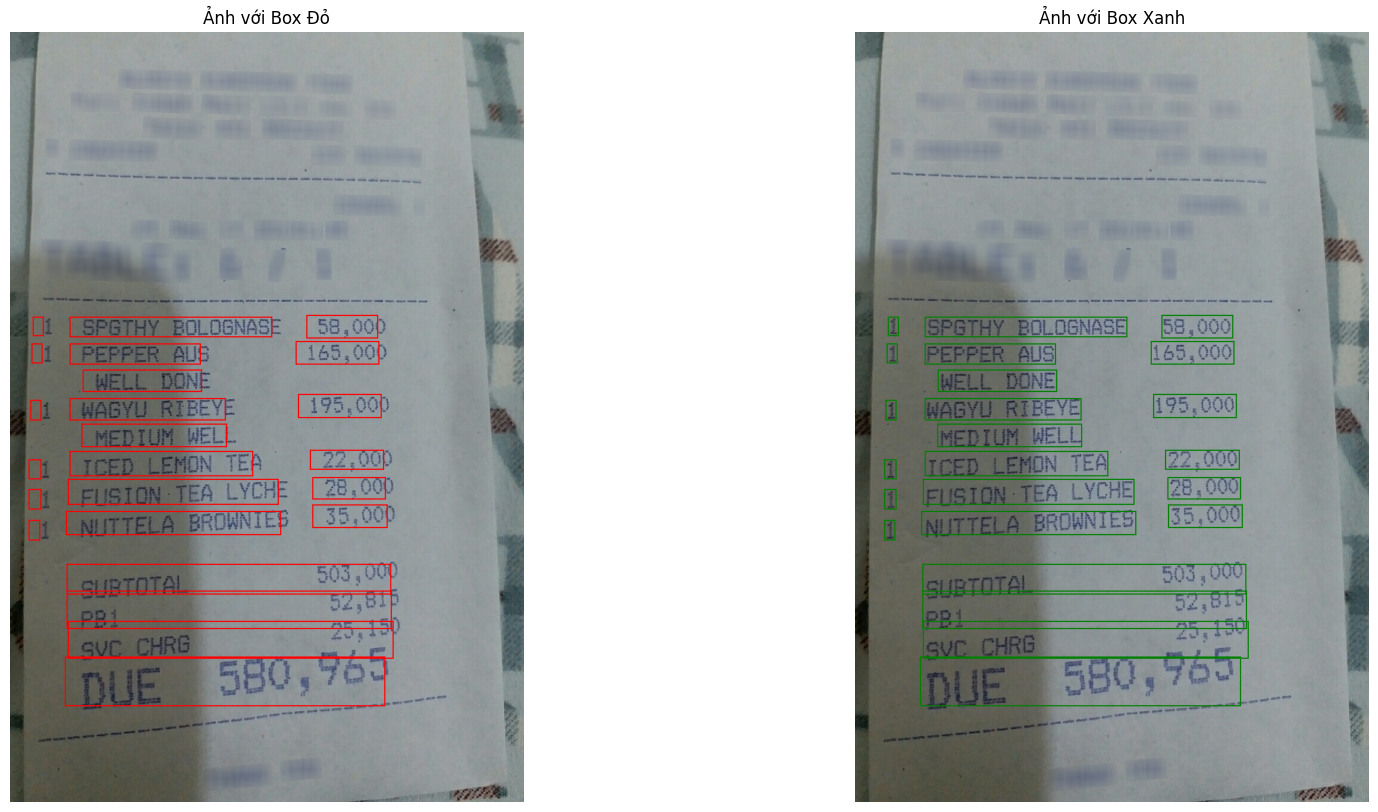

In [115]:
# Tạo 2 bản sao của ảnh gốc để vẽ riêng từng loại box
example = dataset_cord["train"][1]
image = example['image']
width, height = image.size
bboxes = example['bboxes']

# Reset ảnh từ gốc
image_red = image.copy()
image_green = image.copy()

# Tạo đối tượng vẽ cho từng ảnh
draw_red = ImageDraw.Draw(image_red)
draw_green = ImageDraw.Draw(image_green)

# Vẽ các box lên từng ảnh
for bbox in bboxes:
    # Tính toán box cho ảnh chứa box đỏ
    scaled_bbox_red = scale_bbox(perturb_bbox(bbox, img_size=(width, height)), width, height)
    draw_red.rectangle(scaled_bbox_red, outline="red", width=2)
    
    # Tính toán box cho ảnh chứa box xanh
    scaled_bbox_green = scale_bbox(bbox, width, height)
    draw_green.rectangle(scaled_bbox_green, outline="green", width=2)
    # print(scaled_bbox_red, scaled_bbox_green)

# Hiển thị 2 ảnh riêng biệt
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.imshow(image_red)
plt.axis('off')
plt.title("Ảnh với Box Đỏ")

plt.subplot(1, 2, 2)
plt.imshow(image_green)
plt.axis('off')
plt.title("Ảnh với Box Xanh")

plt.show()


# Load dataset SROIE

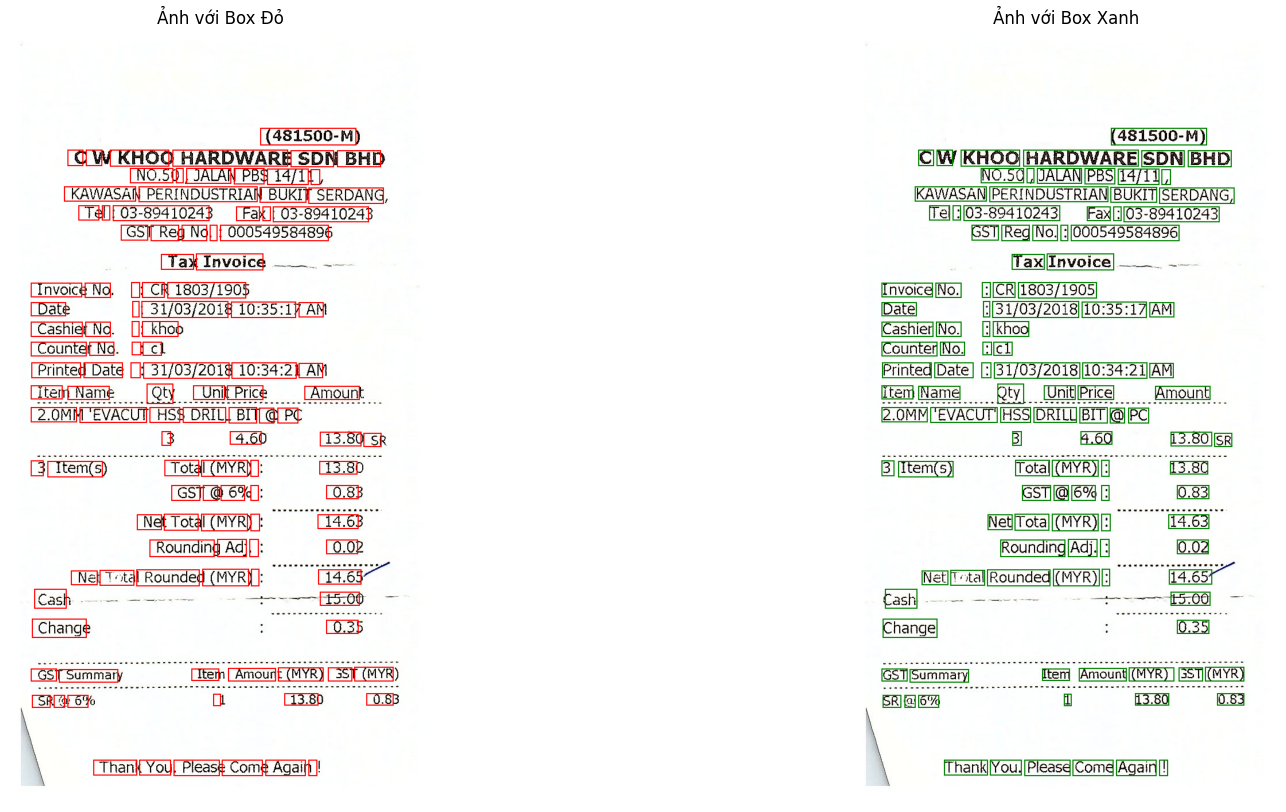

In [131]:
import os
import json
from PIL import Image, ImageDraw

datadir_path = os.path.join("data")
image_folder = os.path.join(datadir_path, "sroie/test/images")
json_folder = os.path.join(datadir_path, "sroie/test/tagged")
output_folder = os.path.join(datadir_path, "sroie/test/images_draw")
os.makedirs(output_folder, exist_ok=True)

all_f1 = []
all_f1_perturbed = []
list_image = os.listdir(image_folder)

choice_index = 2
image_name = list_image[choice_index]
json_name = image_name.replace(".jpg", ".json")
json_path = os.path.join(json_folder, json_name)

image_path = os.path.join(image_folder, image_name)
image = Image.open(image_path).convert("RGB")
width, height = image.size

with open(json_path, "r", encoding="utf-8") as f:
    data_json = json.load(f)

words = data_json["words"]
bboxes = data_json["bbox"]
labels_char = data_json["labels"]

# Tạo bản sao ảnh để vẽ
image_red = image.copy()
image_green = image.copy()

# Tạo đối tượng vẽ
draw_red = ImageDraw.Draw(image_red)
draw_green = ImageDraw.Draw(image_green)

# Vẽ các box
for bbox in bboxes:
    # Perturbed box (vẽ đỏ)
    scaled_perturbed = perturb_bbox(bbox, offset=10, img_size=(width, height))
    draw_red.rectangle(scaled_perturbed, outline="red", width=2)
    
    # Original box (vẽ xanh)
    draw_green.rectangle(bbox, outline="green", width=2)

# Hiển thị 2 ảnh riêng biệt
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.imshow(image_red)
plt.axis('off')
plt.title("Ảnh với Box Đỏ")

plt.subplot(1, 2, 2)
plt.imshow(image_green)
plt.axis('off')
plt.title("Ảnh với Box Xanh")

plt.show()

In [ ]:
from  datasets import load_dataset
from datasets import save_to_disk
from datasets import load_from_disk


In [3]:
doc_laynet = load_dataset("pierreguillou/DocLayNet-base", trust_remote_code=True)
# save_to_disk("data/pierreguillou/DocLayNet-base")

Generating train split: 6910 examples [07:10, 16.05 examples/s]
Generating validation split: 648 examples [00:39, 16.26 examples/s]
Generating test split: 499 examples [00:29, 16.75 examples/s]


In [6]:
doc_laynet["test"].save_to_disk("data/pierreguillou_DocLayNet-base")

Saving the dataset (1/1 shards): 100%|██████████| 499/499 [00:00<00:00, 691.85 examples/s]


In [7]:
from transformers import AutoTokenizer

# tokenizer = AutoTokenizer.from_pretrained("microsoft/layoutxlm-base")
tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")

/home/team_cv/miniconda3/envs/layoutlm/lib/python3.8/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
